# Naive Bayes Classifier for Natural Language Processing

This article will review a bread-and-butter natural language processing (NLP) model known as the Naive Bayes Classifier. We will analyse a series of tweets with binary outcomes from the [kaggle disaster dataset](https://www.kaggle.com/c/nlp-getting-started). These tweets show peoples' online reaction to natural disasters world wide. The goal is to build a model to automatically classify which tweets pertain to disasters and which do not.

In this post we will learn

1): What is a Naive Bayes classifier?

2): Python scikit-learn implementation

3): How do we measure model performance?

##  What is a Naive Bayes Classifier?

Training a model to label a sample of text as positive / negative
is known as Natural Language Processing (NLP) binary classification.

A common choice of model for such a task is the Naive Bayes classifier.
Using [Bayes theorem](https://medium.com/@theflyingmantis/text-classification-in-nlp-naive-bayes-a606bf419f8c
),
we can formulate our outcome variable as the probability of a certain class 0 or 1 given some input text X. In our case, a tweet referring to a recent natural disaster is labeled 1 and a neutral tweet 0. In maths speak this is known as the Naive Bayes probability P(C_j | X), which is calculated from Bayes theorem as

`P(C_j | X) = P(X | C_j) P(C_j) / P(X)`.

From the above, we have three quantities to calculate.

#### __`P(X)`:__ 

Give that all probabilities have P(X) as the denominator, this constant can be disregarded.

#### __`P(C_j)`:__ 

This is simple enough. It is just the relative
fraction of class _i_ in the data set (i.e.
for the positive class, this is the number of
positives divided by the total number of samples
in the training data).

#### __`P(X | C_j)`:__

Representing the input as a set of features
`x1, x2 ...xn, P(X) = P(x1, x2...xn)`.
We can rewrite `P(X | C_j)` as `P(x1,x2...xn | C_j)`.
Now comes the trick. The word _Naive_ in Naive Bayes
classifiers means that we make the assumption that
probabilities of all words are independent of
each other. This chiefly means that we assume
the order of the words doesn't matter (an incorrect assumption
but one that often doesn't introduce too much error), but
 also allows us to rewrite our conditional
 probability as

`P(x1,x2...xn | C_j) = P(x1|C_j) P(x2 | C_j) .... P(xn | C_j)`.

The probability of word 1 given class _j_, `P(x1 | C_j)`, is then

`P(xi | C_j) = count (xi, C_j) / sum_k (xk, C_j)`.

i.e. this counts all occurrences of word _xi_ in
all inputs of class _C_j_ and divides them by the
sum of counts of all words in the vocabulary.
Laplace smoothing can be used to mitigate the
effects of zero occurrences of words and
dividing by zero.

In summary, the Naive Bayes probability for
input _X_, `P(X | C_j) P(C_j)`, is calculated by
multiplying together `P(xi | C_j)` for all words
in our vocabulary and multiplying the result by
`P(C_j)`. Lets now set one up using sci-kit learn.

## Python Scikit-learn Implementation:

Python's scitkit-learn module includes excellent Naive Bayes functionality for building and NLP classifier. To begin, lets load our input data.

In [1]:
#import dependencies
#for data ingestion manipulation
import pandas as pd

#to split data into train/test samples
from sklearn.model_selection import train_test_split

#to generate our sparse matrix of word occurrence counts
from sklearn.feature_extraction.text import CountVectorizer

#to normalise over tweet length and word overuse
from sklearn.feature_extraction.text import TfidfTransformer

#the Naive Bayes classifier and support vector machine for comparison
from sklearn.naive_bayes import MultinomialNB
from sklearn import model_selection, svm

#combine word count, transformation, fit / predict steps into a single pipeline
from sklearn.pipeline import Pipeline

# to compute the ROC curve and Area AUC
from sklearn import metrics

# to visualise the ROC
import matplotlib.pylab as plt

#to sort array
import numpy as np

In [2]:
#load data
df = pd.read_csv('./nlp_data/train.csv')
X, y = list(df['text']), list(df['target'])

In [3]:
#split into train test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Get the word counts for the train data

We now must construct the probabilities _P(X|C_j)_ for each word / class combination. We therefore need the occurrence counts of each word in each of our input samples.

In [4]:
#Get the word counts for the train data
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_train_counts.shape

(5100, 16398)

### Word count transformations

Occurrence count is a good start but there is an issue: longer tweets will have higher 
average count values than shorter tweets, even though they might talk about the same topics.

To avoid these potential discrepancies it suffices to divide the number of 
occurrences of each word in a tweet by the total number of words in 
the tweet: these new features are called tf for Term Frequencies.

Another refinement on top of tf is to downscale weights for words that occur 
in many tweets in the sample and are therefore less informative than those 
that occur only in a smaller portion of the tweets (e.g words like "the", "and" etc)

In [5]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

### Fit the naive bayes classifier

In [6]:
clf = MultinomialNB().fit(X_train_tfidf, y_train)

### predict the labels for the test data

First we get the word counts and apply the transformations as to the test data

In [7]:
X_test_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
y_pred = clf.predict(X_test_tfidf)

### Build a pipeline

The count, transformation and predict steps can be combined into one using scikit-learns pipeline functionality.

In [8]:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),])
text_clf.fit(X_train, y_train)
y_pred = text_clf.predict(X_test)

## How do we Measure Model Performance?

To measure the performance of our classifier, we could simply use an accuracy metric from our true positive (TP), false positive (FP), true negative (TN) and false negative (FN) counts. This is defined as

`accuracy = TP + FP / (TP + FP + TN + FN)`

This is a common performance metric for a classifier but is suceptible to class imballances. When testing for a disease for example, most of the training sample will likely not be infected. In these cases a classifier that always predicted negative would achieve a high accuracy score despite being useless. It is better therefore to use a metric that combines the following concepts:

#### Precision = TP / (TP + FP)
Is the fraction of positive classifications that were correct.

#### Recall = TP / (TP + FN) 
Is the fraction of positive that were identified by the classifier.


Remember that classifiers output the probability of an input belonging to each class. We then choose an arbitrary threshold probability to say whether the probability indicates one class or another. A good way of measuring the performance of a classifier is to construct the [ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) curve trailing various threshold probabilities, and measuring the area under the curve (AUC). Fortunately, scikit-learn comes to the rescue again.

In [9]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
auc = metrics.auc(fpr, tpr)
print('ROC curve AUC = '+str(auc))

ROC curve AUC = 0.7799776651746537


### Support Vector Machine (SVM) comparison

We can also compare this with a slightly more sophisticated Support Vector Machine (SVM) classifier. Interested readers can learn more about the theory behind the model [here](https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47). We will focus on its pythonic implementation and consider the theory a black box for now.

In [18]:
# Classifier - Algorithm - SVM
text_clf_svm = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')),])
text_clf_svm.fit(X_train, y_train)
y_pred_svm = text_clf_svm.predict(X_test)

#performance of SVM
fpr_svm, tpr_svm, thresholds_svm = metrics.roc_curve(y_test, y_pred_svm, pos_label=1)
auc_svm = metrics.auc(fpr_svm, tpr_svm)
print('ROC curve AUC (SVM) = '+str(auc_svm))

ROC curve AUC (SVM) = 0.7946803449648125


### Visualising ROC curve

We can plot the roc curve as true positive rate vs false positive rate using matplotlib.

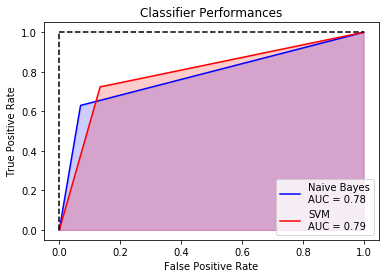

In [17]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
for fpr_now, tpr_now, auc_now, lab, col in zip([fpr,fpr_svm],[tpr, tpr_svm],[auc, auc_svm], ['Naive Bayes','SVM'],['b','r']):
    idx = np.argsort(fpr)
    x, y = fpr_now[idx],tpr_now[idx]
    ax1.plot(x,y,label=lab+'\nAUC = '+str(np.round(auc_now,2)),color=col)
    ax1.fill_between(x, np.zeros(len(y)), y,color=col,alpha=0.2)
ax1.plot([0,0],[0,1],label=None,ls='--',color='k')
ax1.plot([0,1],[1,1],label=None,ls='--',color='k')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Classifier Performances')
plt.legend()

plt.show()

Here we can visualise the performance of our Naive Bayes classifier vs a theoretical 'perfect' classifier enclosed by the dashed lines with an area of 1. The SVM performs slight better but the difference is marginal.

# Summary

Here we have quickly reviewed the stats behind the Naive Bayes text classification algorithm, constructed a Naive Bayes classifier in Python and written code to measure its performance. We have also compared this to a Support Vector Machine (SVM) classifier and found no to marginal difference in this case.

Naive Bayes models are one of the simpler text classification models and often outperformed by neural net type methods (long short term memory networks are a good choice for text classification). Despite this, simpler models mean less potential for the model to overfit, a smaller training sample, and the simpler model interpret-ability. Opting for a simpler classifier model over a neural net can save lots of pain further down the line and will often get you then answer you need, and perform almost as well.